In [1]:
!pip install datasets transformers evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.5 MB/s eta 0:00:00


In [49]:
import numpy  as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

In [3]:
# read test and trian data and use Dataset library
data = DatasetDict()
df_train = pd.read_csv("/content/train.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_train = df_train.rename(columns={'Relevance': 'label'})
data['train'] = Dataset.from_pandas(df_train)
df_test = pd.read_csv("/content/test.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_test = df_test.rename(columns={'Relevance': 'label'})
df_test_unfreeze=df_test.copy()
df_test_unfreeze_11=df_test.copy()
df_test_freeze=df_test.copy()
data['test'] = Dataset.from_pandas(df_test)

In [7]:
from transformers import BertForMaskedLM, BertTokenizer, pipeline
tokenizer = BertTokenizer.from_pretrained('arm-on/BERTweet-FA')

In [9]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["Record_text"], padding=True, truncation=True, max_length = 50)
# Tokenize entire dataset
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/10856 [00:00<?, ? examples/s]

Map:   0%|          | 0/2383 [00:00<?, ? examples/s]

In [11]:
#Select mode of model
def freeze(model,mode):
    if mode=='unfreeze':
       for layer in model.get_layer('bert').encoder.layer:
            print(f"{layer.name}: {layer.trainable}")
    elif mode=='unfreeze_11':
       for layer in model.layers:
           layer.trainable = False
       model.get_layer('bert').encoder.layer[11].trainable=True  #11
       model.layers[-1].trainable = True   #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    else:
       for layer in model.layers:
           layer.trainable = False
       model.layers[-1].trainable = True  #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    return model

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [13]:
# Create tf datasets
BAtch_Size = 128
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns= ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)
tf_valid_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=False,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [14]:
def compile(model):
  # Compile the model
  model.compile(
    optimizer=optimizers.Adam(learning_rate=9e-5),
    loss=model.hf_compute_loss,
    metrics=metrics.SparseCategoricalAccuracy()
)
  return model

In [15]:
def training(model,Epoch):
    EPOCHS = Epoch
    checkpoint_filepath = '/content/"training\cp.ckpt" '
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(tf_train_dataset,
              validation_data=tf_valid_dataset,
              epochs=EPOCHS)
             # callbacks=[model_checkpoint_callback])


In [16]:
#Mode
mode=['unfreeze','unfreeze_11','freeze']

## Mode: Un-freeze

In [17]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [45]:
num_labels = 2

model_ = TFBertForSequenceClassification.from_pretrained('arm-on/BERTweet-FA',num_labels=num_labels,

                                                            id2label={0: 'irrelevant', 1: 'relevant'}, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
model_=freeze(model_,mode[0])

layer_._0: True
layer_._1: True
layer_._2: True
layer_._3: True
layer_._4: True
layer_._5: True
layer_._6: True
layer_._7: True
layer_._8: True
layer_._9: True
layer_._10: True
layer_._11: True


In [47]:
#Compile
model_=compile(model_)

 2,3,5,10,15 were tested

#### Epoch=2

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------





In [48]:
training(model_,2)

Epoch 1/2
85/85 [==============================] - 162s 1s/step - loss: 0.5721 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.4802 - val_sparse_categorical_accuracy: 0.7877
Epoch 2/2
85/85 [==============================] - 116s 1s/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8518 - val_loss: 0.4639 - val_sparse_categorical_accuracy: 0.7986


---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

In [50]:
def pred_label(text):
    inputs = tokenizer(text, return_tensors="tf")
    logits =  model_(inputs).logits
    #logits =  model_unfreeze_11(inputs).logits
   # logits =  model_freeze(inputs).logits
      # print(logits)
    predict = int(tf.math.argmax(logits, axis=-1)[0])
      # print(predict)
    return predict
def Evaluate_models(df_test,model,label,mode):
    print(f":::::::::::::::Performance of ParsBERT'{mode}' on '{label}' Label:::::::::::::::::::")
    df_test["pred_label"]= df_test["Record_text"].apply(lambda x:pred_label(x))
    Real_label = df_test["label"].values
    predictions = df_test["pred_label"].values
    accuracy = accuracy_score(Real_label, predictions)
    print(classification_report(Real_label, predictions, labels=[0, 1], zero_division=0))
        #accuracy = accuracy_score(y_test, preds[i])
    print(f'''Accuracy: {round(accuracy_score(Real_label, predictions, normalize=True),6)}
    \nPrecision:{round(precision_score(Real_label, predictions, average='macro'),6)}
    \nRecall: {round(recall_score(Real_label, predictions, average='macro'),6)}
    \nF1 score: {round(f1_score(Real_label, predictions, average='macro'),6)}''')
    print('\n')
    print('\n')
    print('\n')
    print('-----------------------------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    # confusion_matrix = metrics.confusion_matrix(Real_label, predictions)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    # cm_display.plot()
    # plt.show()
    return df_test

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------




In [51]:
Evaluate_models(df_test_unfreeze,model_,'Relevance',mode[0])

:::::::::::::::Performance of ParsBERT'unfreeze' on 'Relevance' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1156
           1       0.81      0.82      0.81      1227

    accuracy                           0.81      2383
   macro avg       0.81      0.80      0.81      2383
weighted avg       0.81      0.81      0.81      2383

Accuracy: 0.805287
    
Precision:0.805179
    
Recall: 0.804964
    
F1 score: 0.805051






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,label,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,-1,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,1
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,0
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,-1,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,1
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,0,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,0
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,0,1,1,0.0,3,حرف ازدواج اصلا نزن,1,0
...,...,...,...,...,...,...,...,...,...
2378,وقتی اکثرا از عمه هاتون بدتون میاد و خاله هاتو...,-1,0,3,0.0,3,کامنت,0,1
2379,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,1,1,2,1.0,2,کامنت,1,1
2380,همسر عزیز قهرمانم،تولدت با روز جمهوری اسلامی ی...,-1,0,3,0.0,3,کامنت,0,1
2381,ببینین این خصوصیات رو خود شما یا پارتنرتون دار...,-1,0,3,0.0,3,کامنت,0,1


----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_test_unfreeze_irrelevant= df_test_unfreeze[(df_test_unfreeze['label'] == 0) & (df_test_unfreeze['pred_label'] == 0)]
df_test_unfreeze_relevant = df_test_unfreeze[(df_test_unfreeze['label'] == 1) & (df_test_unfreeze['pred_label'] == 1)]

In [ ]:
df_test_unfreeze_irrelevant.to_csv('/content/df_test_unfreeze_irrelevant.csv')
df_test_unfreeze_relevant.to_csv('/content/df_test_unfreeze_relevant.csv')


In [ ]:
df_test_unfreeze.to_csv('/content/df_test_unfreeze_relevance.csv')


## Mode: Freeze except layer 11


In [ ]:
num_labels=2
model_unfreeze_11 = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'irrelevant', 1: 'relevant'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_unfreeze_11=freeze(model_unfreeze_11,mode[1])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: True


In [ ]:
#Compile
model_unfreeze_11=compile(model_unfreeze_11)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

#### Epoch=50

In [ ]:
training(model_unfreeze_11,50)

Epoch 1/50
85/85 [==============================] - 63s 578ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.5634 - val_loss: 0.6664 - val_sparse_categorical_accuracy: 0.6060
Epoch 2/50
85/85 [==============================] - 46s 541ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.5942 - val_loss: 0.6550 - val_sparse_categorical_accuracy: 0.6261
Epoch 3/50
85/85 [==============================] - 47s 559ms/step - loss: 0.6548 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.6468 - val_sparse_categorical_accuracy: 0.6379
Epoch 4/50
85/85 [==============================] - 46s 543ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6247 - val_loss: 0.6413 - val_sparse_categorical_accuracy: 0.6479
Epoch 5/50
85/85 [==============================] - 45s 528ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.6295 - val_loss: 0.6378 - val_sparse_categorical_accuracy: 0.6441
Epoch 6/50
85/85 [==============================] - 45s 535ms/step - loss: 0.6358 - sparse_cate

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'unfreeze_11' on 'Relevance' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.70      0.60      0.64      1156
           1       0.67      0.76      0.71      1227

    accuracy                           0.68      2383
   macro avg       0.68      0.68      0.68      2383
weighted avg       0.68      0.68      0.68      2383

Accuracy: 0.680235
    
Precision:0.683113
    
Recall: 0.677824
    
F1 score: 0.676931






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


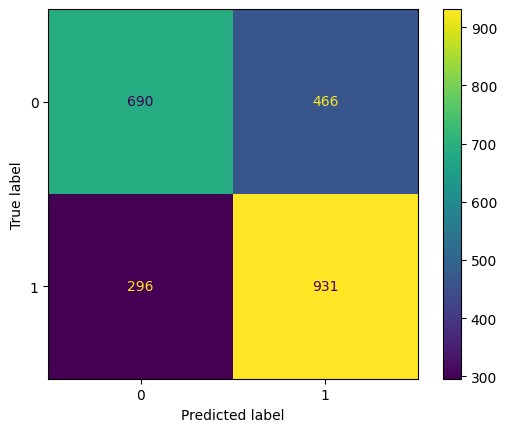

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,label,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,-1,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,0
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,0
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,-1,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,1
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,0,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,1
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,0,1,1,0.0,3,حرف ازدواج اصلا نزن,1,1
...,...,...,...,...,...,...,...,...,...
2378,وقتی اکثرا از عمه هاتون بدتون میاد و خاله هاتو...,-1,0,3,0.0,3,کامنت,0,1
2379,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,1,1,2,1.0,2,کامنت,1,1
2380,همسر عزیز قهرمانم،تولدت با روز جمهوری اسلامی ی...,-1,0,3,0.0,3,کامنت,0,0
2381,ببینین این خصوصیات رو خود شما یا پارتنرتون دار...,-1,0,3,0.0,3,کامنت,0,1


In [ ]:
Evaluate_models(df_test_unfreeze_11,model_unfreeze_11,'Relevance',mode[1])

----------------------------------------------------------------------------------------------------------------------------------------------------------------

## Mode: Freeze

In [ ]:
num_labels=2
model_freeze = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'irrelevant', 1: 'relevant'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_freeze=freeze(model_freeze,mode[2])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: False


In [ ]:
#Compile
model_freeze=compile(model_freeze)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

In [ ]:
training(model_freeze,50)

Epoch 1/50
85/85 [==============================] - 71s 590ms/step - loss: 0.6904 - sparse_categorical_accuracy: 0.5306 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.5749
Epoch 2/50
85/85 [==============================] - 45s 536ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.5830 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6072
Epoch 3/50
85/85 [==============================] - 46s 539ms/step - loss: 0.6599 - sparse_categorical_accuracy: 0.6068 - val_loss: 0.6536 - val_sparse_categorical_accuracy: 0.6232
Epoch 4/50
85/85 [==============================] - 46s 545ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.6173 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.6332
Epoch 5/50
85/85 [==============================] - 48s 570ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.6263 - val_loss: 0.6424 - val_sparse_categorical_accuracy: 0.6362
Epoch 6/50
85/85 [==============================] - 46s 545ms/step - loss: 0.6407 - sparse_cate

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'freeze' on 'Relevance' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      1156
           1       0.66      0.73      0.70      1227

    accuracy                           0.67      2383
   macro avg       0.67      0.67      0.67      2383
weighted avg       0.67      0.67      0.67      2383

Accuracy: 0.671003
    
Precision:0.671937
    
Recall: 0.669234
    
F1 score: 0.66892






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


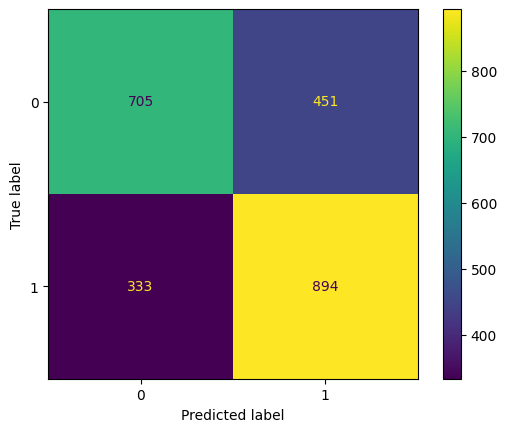

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,label,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,-1,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,0
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,0
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,-1,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,1
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,0,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,1
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,0,1,1,0.0,3,حرف ازدواج اصلا نزن,1,1
...,...,...,...,...,...,...,...,...,...
2378,وقتی اکثرا از عمه هاتون بدتون میاد و خاله هاتو...,-1,0,3,0.0,3,کامنت,0,1
2379,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,1,1,2,1.0,2,کامنت,1,1
2380,همسر عزیز قهرمانم،تولدت با روز جمهوری اسلامی ی...,-1,0,3,0.0,3,کامنت,0,0
2381,ببینین این خصوصیات رو خود شما یا پارتنرتون دار...,-1,0,3,0.0,3,کامنت,0,1


In [ ]:
Evaluate_models(df_test_freeze,model_freeze,'Relevance',mode[2])